# Project: Wrangle and Analyze Data

<hr>

# 1. Gathering Data 

In [3]:
# all librires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# load all dataset about tweet

twitter_archive=pd.read_csv('twitter-archive-enhanced.csv')
tweet_json=pd.read_json('tweet-json.txt',lines=True)




#### Load image prediction Programitcally

In [44]:
# loading the data of image prediction
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
data = requests.get(url)
with open (url.split('/')[-1], mode='wb') as file:
    file.write(data.content)

In [45]:
# read and check
image_data = pd.read_csv('image-predictions.tsv', sep='\t')
image_data.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# 2. Assessing Data

#### just to remember 
**assess them visually and programmatically for quality and tidiness issues.**

- Detect and document at least eight (8) quality issues
- two (2) tidiness issues

In [30]:
# take a look of a sample of twitter_archive Dataframe
twitter_archive.sample(25)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
483,814986499976527872,NaN,NaN,2016-12-31 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. Someone attacked him with a sh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/814986499...,11,10,Cooper,None,None,pupper,None
655,791784077045166082,NaN,NaN,2016-10-27 23:30:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I'm not sure what this dog is d...,6.820881e+17,4.196984e+09,2015-12-30 06:37:25 +0000,"https://vine.co/v/iqMjlxULzbn,https://vine.co/...",12,10,None,None,None,None,None
1361,703079050210877440,NaN,NaN,2016-02-26 04:48:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Butternut Cumberfloof. It's not wind...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/703079050...,11,10,a,None,None,None,None
741,780496263422808064,NaN,NaN,2016-09-26 19:56:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bell. She likes holding...,7.424232e+17,4.196984e+09,2016-06-13 18:27:32 +0000,https://twitter.com/dog_rates/status/742423170...,12,10,Bell,None,None,None,None
1658,683111407806746624,NaN,NaN,2016-01-02 02:23:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Larry. He thought the New Year's parti...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/683111407...,10,10,Larry,None,None,pupper,None
2045,671528761649688577,NaN,NaN,2015-12-01 03:18:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He's in the middle of a serious conv...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671528761...,10,10,Jax,None,None,None,None
1633,684241637099323392,NaN,NaN,2016-01-05 05:14:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Obi. He got camera shy. 12/10 https://...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684241637...,12,10,Obi,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
454,818536468981415936,NaN,NaN,2017-01-09 19:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tom. He's a silly dog. Known for his u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818536468...,11,10,Tom,None,None,None,None


In [29]:
# take a look to info of twitter_archive
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [27]:
# take a look of a sample of image Dataframe

image_data.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
218,670073503555706880,https://pbs.twimg.com/media/CUyUSuWXIAAZKYF.jpg,1,malamute,0.601886,True,Siberian_husky,0.340106,True,Eskimo_dog,0.050041,True
37,666454714377183233,https://pbs.twimg.com/media/CT-5Bs-WUAA2JeC.jpg,1,dalmatian,0.278954,True,Labrador_retriever,0.237612,True,Great_Pyrenees,0.171106,True
670,683098815881154561,https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg,1,golden_retriever,0.889848,True,kuvasz,0.053008,True,Labrador_retriever,0.037881,True
240,670442337873600512,https://pbs.twimg.com/media/CU3jwAYWwAAhdAv.jpg,1,Sussex_spaniel,0.403552,True,otterhound,0.256302,True,Irish_terrier,0.187315,True
1556,793210959003287553,https://pbs.twimg.com/media/CwINKJeW8AYHVkn.jpg,1,doormat,0.874431,False,French_bulldog,0.018759,True,Boston_bull,0.015134,True
972,706644897839910912,https://pbs.twimg.com/ext_tw_video_thumb/70664...,1,space_heater,0.137871,False,Chihuahua,0.132928,True,cougar,0.113866,False
791,690690673629138944,https://pbs.twimg.com/media/CZXTgKkWwAA5UZJ.jpg,1,bath_towel,0.194532,False,radiator,0.127776,False,Maltese_dog,0.089625,True
141,668567822092664832,https://pbs.twimg.com/media/CUc64knWoAkZt70.jpg,1,Shih-Tzu,0.985649,True,Lhasa,0.007078,True,Pekinese,0.003053,True
924,702321140488925184,https://pbs.twimg.com/media/Cb8lWafWEAA2q93.jpg,3,West_Highland_white_terrier,0.769159,True,Scotch_terrier,0.064369,True,Old_English_sheepdog,0.043763,True
430,674269164442398721,https://pbs.twimg.com/media/CVt8OmIWIAAbxvJ.jpg,1,pug,0.622921,True,Norwegian_elkhound,0.048659,True,Cardigan,0.016966,True


In [25]:
# take a look to info of image_data
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# take a look of a sample of tweet_json DataFrame

tweet_json.sample(20)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
1002,2016-06-28 15:40:07+00:00,747816857231626240,747816857231626240,Viewer discretion is advised. This is a terrib...,False,"[0, 114]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 747816839879757824, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,5346,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
18,2017-07-22 00:23:06+00:00,888554962724278272,888554962724278272,This is Ralphus. He's powering up. Attempting ...,False,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 888554915546542081, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,20290,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1655,2016-01-02 04:27:31+00:00,683142553609318400,683142553609318400,Meet Brandy. She's a member of the Bloods. Men...,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 683142548005777412, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3162,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
384,2017-02-01 17:44:55+00:00,826848821049180160,826848821049180160,This is Cupid. He was found in the trash. Now ...,False,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 826848814229237760, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,40325,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1666,2015-12-31 19:05:54+00:00,682638830361513985,682638830361513984,I have no words. Just a magnificent pup. 12/10...,False,"[0, 70]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 682638783267889155, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,2266,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
454,2017-01-09 04:04:51+00:00,818307523543449600,818307523543449600,RT @dog_rates: Meet Moose. He doesn't want his...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,True,False,NaN,NaN,en,{'created_at': 'Wed Jan 04 01:05:59 +0000 2017...,NaN,NaN,NaN
165,2017-05-04 00:15:58+00:00,859924526012018688,859924526012018688,Meet Milky. She has no idea what happened. Jus...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 859924516142804992, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,20021,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
560,2016-11-26 21:26:58+00:00,802624713319034886,802624713319034880,"RT @dog_rates: ""Yep... just as I suspected. Yo...",False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 777684227185868800, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,0.0,0.0,en,{'created_at': 'Mon Sep 19 01:42:24 +0000 2016...,NaN,NaN,NaN
1573,2016-01-14 03:28:06+00:00,687476254459715584,687476254459715584,This is Curtis. He's a fluffball. 11/10 would ...,False,"[0, 86]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 687476249128734720, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,2187,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1463,2016-02-02 02:53:12+00:00,694352839993344000,694352839993344000,Meet Oliviér. He takes killer selfies. Has a d...,False,"[0, 147]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 694352832733040641, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,2244,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [28]:
# take a look to info of tweet_json
tweet_json.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [33]:
#check the columen list 

list(twitter_archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [35]:
#check the columen list 
list(image_data)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [36]:
# check describe
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [38]:
# check duplicated values row

image_data[image_data.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [39]:
# check the value counts row

twitter_archive.tweet_id.value_counts()

700151421916807169    1
674764817387900928    1
794926597468000259    1
701570477911896070    1
715220193576927233    1
                     ..
674742531037511680    1
756651752796094464    1
743545585370791937    1
770655142660169732    1
749075273010798592    1
Name: tweet_id, Length: 2356, dtype: int64

In [42]:
# check sum null 
sum(image_data.img_num.isnull())

0


## Quality Issue

`image_data` **table**

-   Wrong Datatype img_num Column should be in string

`twitter_archive` **table**


-    Change tweet_id from an integer to a string .
-    Timestamp is not of datetime format .

**remove columns with too many missing values.**

- retweeted_status_user_id
-       retweeted_status_id
-       retweeted_status_timestamp
-       in_reply_to_user_id
-       in_reply_to_status_id


## Tidiness Issue

-  doggo, floofer, pupper, puppo these 4 variables shoule be combined into one categorical variable Dog Type, in `twitter_archive` **table**

-   merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes .



<hr>

# 3. Cleaning Data


In [58]:
# copies of all data to Cleaning process
twitter_archive_copy=twitter_archive.copy()
tweet_json_copy=tweet_json.copy()
image_data_copy=image_data.copy()

<hr>


## Quality Issue

`image_data` **table**

-   Wrong Datatype img_num Column should be in string

`twitter_archive` **table**


-    Change tweet_id from an integer to a string .
-    Timestamp is not of datetime format .

**remove columns with too many missing values.**

- retweeted_status_user_id
-       retweeted_status_id
-       retweeted_status_timestamp
-       in_reply_to_user_id
-       in_reply_to_status_id




<hr>

### define

Convert img_num  astype to (str )

### code

In [59]:
#Convert img_num astype to (str )

image_data_copy['img_num'] = image_data_copy['img_num'].astype(str)

### test

In [60]:
#test the data types for image data
image_data_copy.dtypes

tweet_id      int64
jpg_url      object
img_num      object
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

<hr>

### define

from twitter_archive table Change tweet_id column astype to string .

### code

In [61]:
#Change tweet_id column astype to string .
twitter_archive_copy['tweet_id'] = twitter_archive_copy['tweet_id'].astype(str)

### test

In [62]:
# test the code
twitter_archive_copy.dtypes

tweet_id                       object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

<hr>

### define

from twitter_archive table Change timestamp column to_datatime  .


### code

In [63]:
#from twitter_archive table convert timestamp column to_datatime .

twitter_archive_copy.timestamp = pd.to_datetime(twitter_archive_copy['timestamp'],format = "%Y-%m-%d ")

### test

In [64]:
#check the format of timestamp
twitter_archive_copy.head(4)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None


<hr>

### define

drop column retweeted_status_user_id in twitter_archive

### code

In [65]:
#drop column retweeted_status_user_id in twitter_archive

twitter_archive_copy = twitter_archive_copy.drop('retweeted_status_user_id',axis=1)

### test

In [67]:
#check the column retweeted_status_user_id is drop it ?
print(list(twitter_archive_copy))

['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


<hr>

### define

drop column retweeted_status_id in twitter_archive

### code

In [68]:
#drop column retweeted_status_id in twitter_archive

twitter_archive_copy = twitter_archive_copy.drop('retweeted_status_id',axis=1)

### test

In [69]:
#check the column retweeted_status_id is drop it ?
print(list(twitter_archive_copy))

['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


<hr>

### define

drop column retweeted_status_timestamp in twitter_archive

### code

In [70]:
#drop column retweeted_status_timestamp in twitter_archive

twitter_archive_copy = twitter_archive_copy.drop('retweeted_status_timestamp',axis=1)

### test

In [71]:
#check the column retweeted_status_timestamp is drop it ?
print(list(twitter_archive_copy))

['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


<hr>

### define

drop column in_reply_to_user_id in twitter_archive


### code

In [72]:
#drop column in_reply_to_user_id in twitter_archive

twitter_archive_copy = twitter_archive_copy.drop('in_reply_to_user_id',axis=1)

### test

In [73]:
#check the column in_reply_to_user_id is drop it ?
print(list(twitter_archive_copy))

['tweet_id', 'in_reply_to_status_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


<hr>

### define

drop column in_reply_to_status_id in twitter_archive

### code

In [74]:
#drop column in_reply_to_status_id in twitter_archive

twitter_archive_copy = twitter_archive_copy.drop('in_reply_to_status_id',axis=1)

### test

In [75]:
#check the column in_reply_to_status_id is drop it ?
print(list(twitter_archive_copy))

['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']


<hr>

## Tidiness Issue

-  doggo, floofer, pupper, puppo these 4 variables shoule be combined into one categorical variable Dog Type, in `twitter_archive` **table**

-   merge the dataframe twitter_archive, dataframe image_predictions, and tweet_json dataframes .


<hr>

In [77]:
# only quick check 
twitter_archive_copy.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### define

extract **[ doggo, floofer, pupper, puppo ]** from text these 4 variables and  combined into one categorical variable in Dog Type column

### code

In [78]:
# Extract the text from the columns into the new dog_type colunn
twitter_archive_copy['dog_type'] = twitter_archive_copy['text'].str.extract('(doggo|floofer|pupper|puppo)')

### test

In [80]:
# check value count in dog type column
twitter_archive_copy.dog_type.value_counts()

pupper     265
doggo       93
puppo       37
floofer      4
Name: dog_type, dtype: int64

<hr>

### define

using pyhton command pd.concat we can merge out datasets

### code

In [94]:
# merge all dataset outer join
wrangle_df2 = pd.concat([twitter_archive_copy, image_data_copy, tweet_json], join='outer', axis=1)

### test

In [95]:
# test the new df merge
wrangle_df2.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,39467.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,33819.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,25461.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


<hr>

# 4. Storing

In [96]:
# storing the dataset
wrangle_df2.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

<hr>

# 5. Visualizating and Analyzing Data:

In [97]:
#load new data twitter_archive_master
df = pd.read_csv('twitter_archive_master.csv')

In [98]:
#check dataframe
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,39467.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,33819.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,25461.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,42908.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,41048.0,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


# Insight 1

## - Plot on Count of Dog Types.

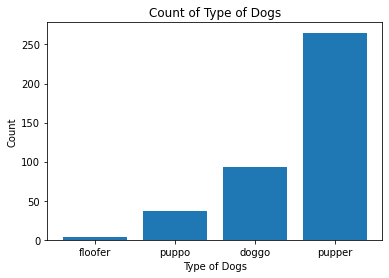

In [102]:
# plot the dog type with y-axis the count of dog and x-axis with name of value count
count=list(df['dog_type'].value_counts().sort_values())
label=list(df['dog_type'].value_counts().sort_values().index)

plt.bar(label,count);
plt.title("Count of Type of Dogs");
plt.xlabel("Type of Dogs");
plt.ylabel("Count");



#### Observation :

   we can clearly see that the most famous dog type is PUPPER followed by Doggo .



<hr>


# Insight 2
## - Plot of count of Image no.

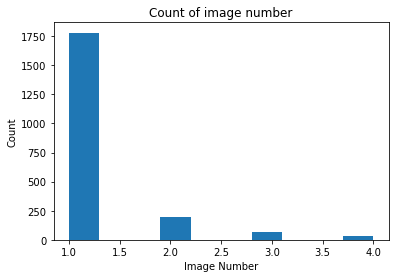

In [109]:
# plot the image number with y-axis the count of image number and x-axis with value count of image number

plt.hist(data =df , x='img_num')
plt.xlabel('Image Number')
plt.ylabel('Count')
plt.title('Count of image number');




#### Observation :

   clearly the Image Number 1 is the most frequent image .



<hr>

# Insight 3
## -  Which dog type have the highest average retweet and favorite-count?

In [117]:
# Retweet count
highest_retweet_count = (df.groupby(['dog_type']).mean()['retweet_count'])
highest_retweet_count.sort_values(ascending = False).head(10)

dog_type
puppo      6038.243243
doggo      4420.268817
floofer    3918.750000
pupper     2676.656604
Name: retweet_count, dtype: float64

In [118]:
# Favorite count
highest_retweet_count = (df.groupby(['dog_type']).mean()['favorite_count'])
highest_retweet_count.sort_values(ascending = False).head(10)

dog_type
puppo      15653.270270
floofer    13422.250000
doggo      11017.720430
pupper      6821.116981
Name: favorite_count, dtype: float64

#### Observation :

   On average the  most type have  retweeted  and favorites is pooupo dog type 
